In [15]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation as mad
import os

In [16]:
# importamos directamente SoupX

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter


# Desactivar los logs de rpy2 para evitar warnings
rcb.logger.setLevel(logging.ERROR)

# Activar la conversión de pandas y AnnData a R
ro.pandas2ri.activate()
anndata2ri.activate()

# Cargar SoupX directamente en Python usando rpy2
try:
    soupx = importr("SoupX")
    print("SoupX loaded successfully!")
except Exception as e:
    print(f"Error loading SoupX: {e}")

# Opcional: si prefieres seguir usando las celdas mágicas, asegúrate de que la extensión esté cargada
%load_ext rpy2.ipython


/home/evercher/tmpdir/ipykernel_24249/4024169881.py:16: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


SoupX loaded successfully!
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


En el tutorial cargan el objeto Anndata directamente.
En este caso, se cargará el objeto Anndata desde un archivo .h5ad que ya ha sido eliminadas las células de calidad baja.

In [55]:
# Función para identificar outliers usando MAD (Median Absolute Deviation)
def mad_outlier(adata, metric, nmads):
    M = adata.obs[metric]
    return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))

# Función para procesar y aplicar el filtrado QC
def pp(adata):
    # Calcular las métricas QC
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],
                               inplace=True, percent_top=[20], log1p=True)
    
    # Filtrar outliers
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) + \
                  mad_outlier(adata, 'log1p_n_genes_by_counts', 5) + \
                  mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) + \
                  mad_outlier(adata, 'pct_counts_mt', 3)
    
    adata = adata[~bool_vector]
    
    return adata
    
    # Cargar las matrices filtradas de los seis ratones
mouse_44_filtered = sc.read_h5ad("/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/filtered_matrices/Mouse_44_filtered.h5ad")
mouse_45_filtered = sc.read_h5ad("/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/filtered_matrices/Mouse_45_filtered.h5ad")
mouse_48_filtered = sc.read_h5ad("/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/filtered_matrices/Mouse_48_filtered.h5ad")
mouse_49_filtered = sc.read_h5ad("/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/filtered_matrices/Mouse_49_filtered.h5ad")
mouse_50_filtered = sc.read_h5ad("/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/filtered_matrices/Mouse_50_filtered.h5ad")
mouse_52_filtered = sc.read_h5ad("/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/filtered_matrices/Mouse_52_filtered.h5ad")

# Aplicar el filtrado QC a las matrices
mouse_44_filtered = pp(mouse_44_filtered)
mouse_45_filtered = pp(mouse_45_filtered)
mouse_48_filtered = pp(mouse_48_filtered)
mouse_49_filtered = pp(mouse_49_filtered)
mouse_50_filtered = pp(mouse_50_filtered)
mouse_52_filtered = pp(mouse_52_filtered)


In [56]:
# Función para obtener los clusters para SoupX
def get_soupx_group(adata):
    adata_pp = adata.copy()
    sc.pp.normalize_per_cell(adata_pp)  # Normalización por célula
    sc.pp.log1p(adata_pp)  # Logaritmo natural de los datos
    sc.pp.pca(adata_pp)  # Análisis de componentes principales (PCA)
    sc.pp.neighbors(adata_pp)  # Calcular vecinos
    sc.tl.leiden(adata_pp, key_added="soupx_groups")  # Agrupamiento Leiden
    return adata_pp.obs['soupx_groups']

# Función para preparar los datos para SoupX sin la intersección de genes
def prepare_broth(adata, raw_data_path):
    # Nombres de células y genes
    cells = adata.obs_names
    genes_filtered = adata.var_names
    data = adata.X.T  # Transponer los datos para SoupX

    # Cargar los datos raw
    adata_raw = sc.read_h5ad(raw_data_path)
    
    # Asegurar que los nombres de las variables (genes) sean únicos
    adata_raw.var_names_make_unique()

    # Extraer los datos crudos transpuestos
    raw = adata_raw.X.T

    # Obtener los clusters de SoupX
    soupx_groups = get_soupx_group(adata)

    return data, raw, genes_filtered, cells, soupx_groups


In [ ]:
# Función para aplicar SoupX a los datos
def cook_soup(adata, raw_data_path):
    data, raw, genes, cells, soupx_groups = prepare_broth(adata, raw_data_path)

    # Usar `localconverter` para pasar los objetos de Python a R y viceversa
    with localconverter(anndata2ri.converter):
        ro.globalenv['data'] = data
        ro.globalenv['raw'] = raw
        ro.globalenv['genes'] = genes
        ro.globalenv['cells'] = cells
        ro.globalenv['soupx_groups'] = soupx_groups

        # Ejecutar código R para aplicar SoupX
        ro.r('''
            library(SoupX)
            make_soup <- function(data, raw, genes, cells, soupx_groups){
                rownames(data) = genes
                colnames(data) = cells
                data <- as(data, "sparseMatrix")
                raw <- as(raw, "sparseMatrix")
                sc = SoupChannel(raw, data, calcSoupProfile = FALSE)
                soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
                sc = setSoupProfile(sc, soupProf)
                sc = setClusters(sc, soupx_groups)
                sc = autoEstCont(sc, doPlot=FALSE)
                out = adjustCounts(sc, roundToInt = TRUE)
                return(out)
            }
            out <- make_soup(data, raw, genes, cells, soupx_groups)
        ''')

        # Recuperar la matriz corregida
        out = ro.globalenv['out']

    # Guardar las capas de cuentas corregidas en AnnData
    adata = adata.copy()  # Hacer una copia explícita del objeto
    adata.layers["raw_counts"] = adata.X
    adata.layers["soupX_counts"] = out.T
    adata.X = adata.layers["soupX_counts"]

    # Mostrar el número total de genes antes del filtrado
    print(f"Total number of genes: {adata.n_vars}")

    # Mostrar el número de genes después del filtrado
    print(f"Number of genes after cell filter: {adata.n_vars}")

    return adata

# Definir las rutas de los datos raw y los nombres de las muestras
raw_data_paths = {
    "Mouse_44": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/raw_matrices/Mouse_44-final_raw.h5ad",
    "Mouse_45": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/raw_matrices/Mouse_45-final_raw.h5ad",
    "Mouse_48": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/raw_matrices/Mouse_48-final_raw.h5ad",
    "Mouse_49": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/raw_matrices/Mouse_49-final_raw.h5ad",
    "Mouse_50": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/raw_matrices/Mouse_50-final_raw.h5ad",
    "Mouse_52": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/raw_matrices/Mouse_52-final_raw.h5ad"
}

# Usar las matrices filtradas ya cargadas en memoria (no hace falta cargarlas de nuevo)
adata_list = {
    "Mouse_44": mouse_44_filtered,  # Objeto AnnData que ya está en memoria
    "Mouse_45": mouse_45_filtered,  # Objeto AnnData que ya está en memoria
    "Mouse_48": mouse_48_filtered,  # Objeto AnnData que ya está en memoria
    "Mouse_49": mouse_49_filtered,  # Objeto AnnData que ya está en memoria
    "Mouse_50": mouse_50_filtered,  # Objeto AnnData que ya está en memoria
    "Mouse_52": mouse_52_filtered   # Objeto AnnData que ya está en memoria
}

# Aplicar SoupX a cada muestra
for mouse, adata in adata_list.items():
    adata_list[mouse] = cook_soup(adata, raw_data_paths[mouse])

# Guardar las matrices corregidas en un archivo h5ad
output_dir = "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX"
os.makedirs(output_dir, exist_ok=True)

for mouse, adata in adata_list.items():
    adata.write_h5ad(f"{output_dir}/{mouse}_corrected_SoupX.h5ad")

# Simple normalization and integration just for visualizaiton

In [45]:
import scanorama
from matplotlib.pyplot import rc_context

In [78]:
# Definir las rutas de los archivos corregidos con SoupX
corrected_files = {
    "Mouse_44": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_44_corrected_SoupX.h5ad",
    "Mouse_45": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_45_corrected_SoupX.h5ad",
    "Mouse_48": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_48_corrected_SoupX.h5ad",
    "Mouse_49": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_49_corrected_SoupX.h5ad",
    "Mouse_50": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_50_corrected_SoupX.h5ad",
    "Mouse_52": "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_52_corrected_SoupX.h5ad"
}

# Cargar las matrices corregidas en una lista
corrected_adata_list = [sc.read_h5ad(file) for file in corrected_files.values()]

# O también puedes usar un diccionario si prefieres tener los nombres de los ratones como clave
corrected_adata_dict = {mouse: sc.read_h5ad(file) for mouse, file in corrected_files.items()}

# Visualización rápida de la lista
for mouse, adata in corrected_adata_dict.items():
    print(f"{mouse}: {adata.shape}")

Mouse_44: (1266, 32285)
Mouse_45: (2005, 32285)
Mouse_48: (364, 32285)
Mouse_49: (576, 32285)
Mouse_50: (1988, 32285)
Mouse_52: (1354, 32285)


In [79]:
mice = ["Mouse_44", "Mouse_45", "Mouse_48", "Mouse_49", "Mouse_50", "Mouse_52"]
for i, prop in enumerate(proportions):
    print(f"Porcentaje de conteos corregidos en {mice[i]}: {prop * 100:.2f}%")


Porcentaje de conteos corregidos en Mouse_44: 99.00%
Porcentaje de conteos corregidos en Mouse_45: 99.00%
Porcentaje de conteos corregidos en Mouse_48: 99.00%
Porcentaje de conteos corregidos en Mouse_49: 97.10%
Porcentaje de conteos corregidos en Mouse_50: 92.39%
Porcentaje de conteos corregidos en Mouse_52: 93.50%


In [80]:
# Función para normalizar y seleccionar genes altamente variables
def norm_for_integration(adata):
    sc.pp.filter_genes(adata, min_cells=1, inplace=True)
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=4000, inplace=True, subset=True)
    return adata

# Lista con los nombres de los archivos corregidos
file_paths = [
    "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_44_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_45_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_48_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_49_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_50_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/TFM_enric/03_Analisis_scRNAseq_python/matrices_corregidas_SoupX/Mouse_52_corrected_SoupX.h5ad"
]

# Cargar cada muestra de ratón y aplicar normalización para integración
adatas = [sc.read_h5ad(file) for file in file_paths]
norm_adatas = [norm_for_integration(adata.copy()) for adata in adatas]

In [81]:
# Integrar las muestras normalizadas con Scanorama
scanorama_int = scanorama.integrate_scanpy(norm_adatas)

# Extraer las embeddings integradas
scanorama_int = [adata.obsm['X_scanorama'] for adata in norm_adatas]  # Verificar que se almacenen correctamente


Found 812 genes among all datasets
[[0.         0.90679305 0.81318681 0.50868056 0.39810427 0.39652449]
 [0.         0.         0.93131868 0.60243056 0.40140845 0.36009975]
 [0.         0.         0.         0.4478022  0.42032967 0.54395604]
 [0.         0.         0.         0.         0.84895833 0.87326389]
 [0.         0.         0.         0.         0.         0.88478582]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (4, 5)
Processing datasets (3, 5)
Processing datasets (3, 4)
Processing datasets (0, 2)
Processing datasets (1, 3)
Processing datasets (2, 5)
Processing datasets (0, 3)
Processing datasets (2, 3)
Processing datasets (2, 4)
Processing datasets (1, 4)
Processing datasets (0, 4)
Processing datasets (0, 5)
Processing datasets (1, 5)


In [86]:
# Obtener las dimensiones de cada embedding en la lista scanorama_int
embedding_shapes = [embedding.shape for embedding in scanorama_int]
print(embedding_shapes)

[(1266, 100), (2005, 100), (364, 100), (576, 100), (1988, 100), (1354, 100)]


In [84]:

# Combinar las muestras en un único objeto AnnData
adata = sc.concat(adatas, index_unique='_')

# Asegurarte de añadir las embeddings de Scanorama a los datos combinados
adata.obsm["X_scanorama"] = np.concatenate(scanorama_int, axis=0)  # Aquí concatenas correctamente las embeddings

# Ahora deberías poder calcular los vecinos usando la representación integrada
sc.pp.neighbors(adata, use_rep="X_scanorama")

# Calcular UMAP para la visualización
sc.tl.umap(adata)


In [87]:
# Obtener las capas de datos antes y después de SoupX
before = adata.layers['raw_counts'].copy()
after = adata.layers['soupX_counts'].copy()

# Binarizar las matrices de conteos antes y después de SoupX
before.data = np.where(before.data > 0, 1, 0)
after.data = np.where(after.data > 0, 1, 0)

# Calcular la diferencia entre las matrices binarizadas
diff = before - after

# Crear una matriz binaria indicando dónde se ha eliminado el mRNA ambiental
changed = (diff == 1).astype(int)
adata.layers['changed'] = changed

# Guardar cuántas células han sido afectadas por gen
adata.var['soupX_removed'] = adata.layers['changed'].sum(axis=0).A1

# Ordenar los genes según el número de células en las que se eliminaron
adata.var.sort_values('soupX_removed', ascending=False)

,soupX_removed
Apoe,663
Ccl5,572
Cst3,496
Lyz2,457
C1qb,438
...,...
Rgs20,0
Gm37323,0
Gm37587,0
Sox17,0


In [73]:
# Mostrar las capas disponibles en el objeto AnnData
print(adata.layers.keys())

KeysView(Layers with keys: raw_counts, soupX_counts, changed)


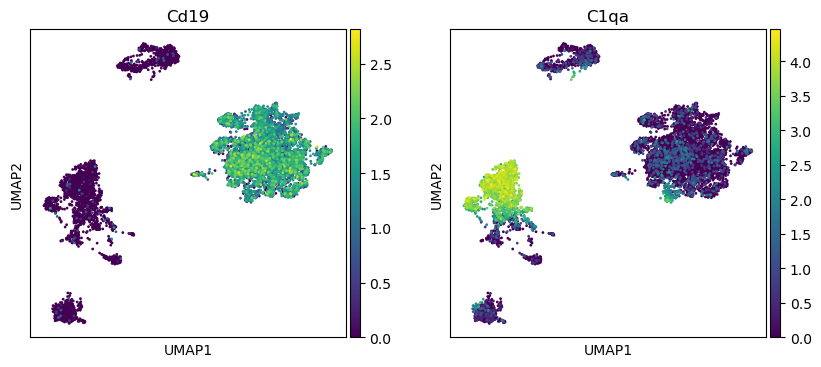

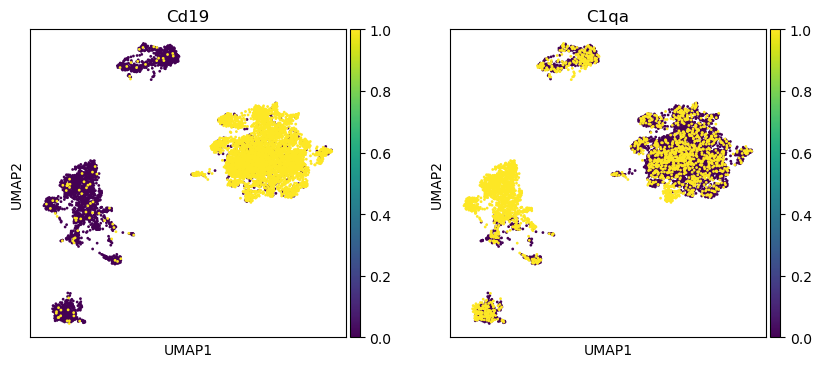

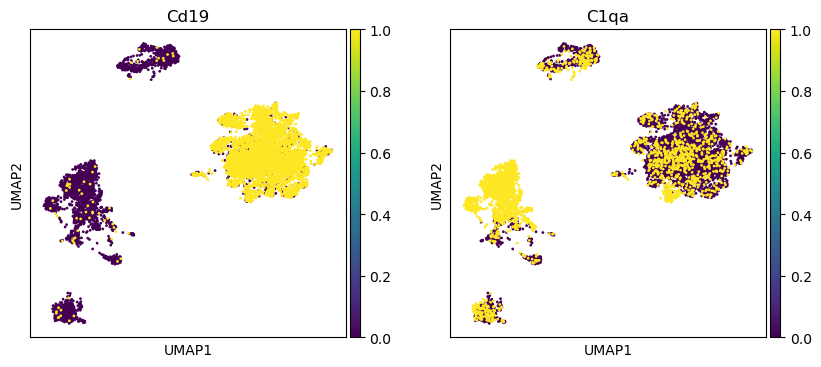

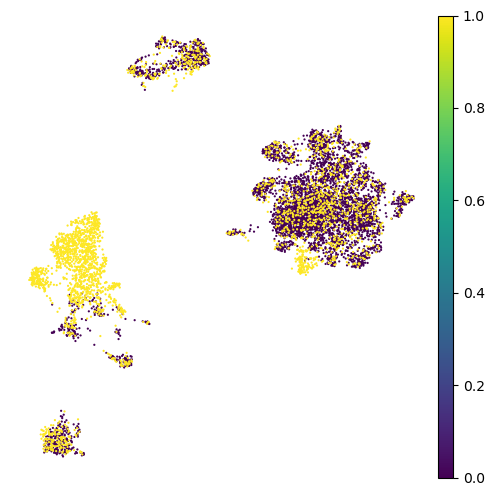

In [89]:
# Normalizar nuevamente los datos para visualización
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

# Visualización de UMAP para los genes de interés
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=['Cd19', 'C1qa'])

# Visualización con la capa de conteos 'raw_counts'
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=['Cd19', 'C1qa'], vmax=1, layer='raw_counts')

# Visualización con la capa de conteos 'soupX_counts'
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=['Cd19', 'C1qa'], vmax=1, layer='soupX_counts')

# UMAP específico para el gen 'Chil3'
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color=['C1qa'], vmax=1, layer='raw_counts', s=10, frameon=False, title='')

# La primera imagen usa los datos corregidos (post SoupX) con normalización y log-transformación estándar.
# La segunda imagen muestra los datos sin corrección (conteos crudos).
# La tercera imagen muestra los datos corregidos directamente usando SoupX, pero sin la transformación adicional.